<a href="https://colab.research.google.com/github/ZobayerAbedin/DeepLearning/blob/main/digitRecognitionSimpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import time
from torchsummary import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Data Manipulation

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path = ['/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/train.csv',
        '/kaggle/input/digit-recognizer/train.csv']
df = pd.read_csv(path[0])


data = df.to_numpy()

labels = data[:, 0]
data = data[:, 1:]

dataNorm = data / np.max(data)
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)
imgSize = 28

In [4]:
## converting to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

trainDataT, testDataT, trainLabelsT, testLabelsT = train_test_split(dataT, labelsT, test_size = 0.1, random_state = 37)

## converting to tensor dataset
trainData = TensorDataset(trainDataT, trainLabelsT)
testData = TensorDataset(testDataT, testLabelsT)

## convert to data loader
batchSize = 16
trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, drop_last = True)
testLoader = DataLoader(testData, batch_size = len(testData), shuffle = True)


# Model


In [5]:
def createCNNNet():
  class CNNNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### Feature Maps
      kernalSize = [3, 3]

      self.conv1 = nn.Conv2d(1, 64, kernalSize, padding = 1)
      self.batchNorm1 = nn.BatchNorm2d(64)
      outSize = (imgSize + 2 * self.conv1.padding[0] - kernalSize[0] + 1) // 2

      self.conv2 = nn.Conv2d(64, 128, kernalSize, padding = 1)
      self.batchNorm2 = nn.BatchNorm2d(128)
      outSize = (outSize + 2 * self.conv2.padding[0] - kernalSize[0] + 1) // 2

      self.conv3 = nn.Conv2d(128, 256, kernalSize, padding = 1)
      self.batchNorm3 = nn.BatchNorm2d(256)
      outSize = (outSize + 2 * self.conv3.padding[0] - kernalSize[0] + 1) // 2

      self.conv4 = nn.Conv2d(256, 512, kernalSize, padding = 1)
      self.batchNorm4 = nn.BatchNorm2d(512)
      outSize = (outSize + 2 * self.conv4.padding[0] - kernalSize[0] + 1) // 2

      ### Linear Layers

      self.fc1 = nn.Linear(outSize * outSize * self.conv4.out_channels, 512)
      self.fc2 = nn.Linear(512, 256)
      self.fc3 = nn.Linear(256, 128)
      self.fc4 = nn.Linear(128, 64)
      self.fc5 = nn.Linear(64, 10)



    def forward(self, x):

      ### Convulation Operations
      x = F.max_pool2d(self.conv1(x), 2)
      x = F.relu(self.batchNorm1(x))

      x = F.max_pool2d(self.conv2(x), 2)
      x = F.relu(self.batchNorm2(x))

      x = F.max_pool2d(self.conv3(x), 2)
      x = F.relu(self.batchNorm3(x))

      x = F.max_pool2d(self.conv4(x), 2)
      x = F.relu(self.batchNorm4(x))


      ### Linear Layers
      x = x.reshape(x.shape[0],-1)

      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x, p = 0.1, training = self.training)

      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x, p = 0.1, training = self.training)

      x = F.leaky_relu(self.fc3(x))
      x = F.dropout(x, p = 0.1, training = self.training)

      x = F.leaky_relu(self.fc4(x))
      x = F.dropout(x, p = 0.1, training = self.training)


      x = self.fc5(x)

      return x

  net = CNNNet()

  lossFun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)


  return net, lossFun, optimizer



In [6]:
net, lossFun, optimizer = createCNNNet()
net = net.to(device)
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 14, 14]             128
            Conv2d-3          [-1, 128, 14, 14]          73,856
       BatchNorm2d-4            [-1, 128, 7, 7]             256
            Conv2d-5            [-1, 256, 7, 7]         295,168
       BatchNorm2d-6            [-1, 256, 3, 3]             512
            Conv2d-7            [-1, 512, 3, 3]       1,180,160
       BatchNorm2d-8            [-1, 512, 1, 1]           1,024
            Linear-9                  [-1, 512]         262,656
           Linear-10                  [-1, 256]         131,328
           Linear-11                  [-1, 128]          32,896
           Linear-12                   [-1, 64]           8,256
           Linear-13                   [-1, 10]             650
Total params: 1,987,530
Trainable param

In [7]:
data = trainLoader.dataset.tensors[0][0:16]
labels = trainLoader.dataset.tensors[1]


print(data.shape)
# pred = net(data)

torch.Size([16, 1, 28, 28])


# Test


In [8]:
def testNet(net, lossFun, optimizer, testLoader):
  data = testLoader.dataset.tensors[0]
  labels = testLoader.dataset.tensors[1]
  net.eval()

  if device != 'cpu':
    data = data.to(device)
    labels = labels.to(device)

  with torch.no_grad():
    pred = net(data)

  if device != 'cpu':
    labels = labels.cpu()
    pred = pred.cpu()

  matches = (torch.argmax(pred, axis = 1) == labels).float()
  acc = 100 * torch.mean(matches)

  return acc


# Train

In [9]:
def trainNet(net, lossFun, optimizer, trainLoader):
  epochs = 30

  timeStart = time.process_time()
  timeNow = timeStart

  trainAcc = []
  trainLoss = []
  testAcc = []

  for epoch in range(epochs):

    net.train()

    batchAcc = []
    batchLoss = []

    for data, labels in trainLoader:

      if device != 'cpu':
        data = data.to(device)
        labels = labels.to(device)

      ## Calculate forward pass and loss
      pred = net(data)
      loss = lossFun(pred, labels)

      ## backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      ## accurecy and loss
      pred = pred.cpu()
      labels = labels.cpu()
      matches = (torch.argmax(pred, axis = 1) == labels).float()
      acc = 100 * torch.mean(matches)

      batchAcc.append(acc)
      batchLoss.append(loss.item())

    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))

    testAcc.append(testNet(net, lossFun, optimizer, testLoader))

    timeTaken = time.process_time() - timeNow
    elapsedTime = time.process_time() - timeStart
    timeNow = time.process_time()

    print(f'Epoch {epoch+1}/{epochs}, time taken: {timeTaken:.2f}, Lelapsed time: {elapsedTime:.2f} sec, test accuracy {testAcc[-1]:.4f}%')

  return trainAcc, testAcc, trainLoss


# main

In [10]:
trainAcc, testAcc, trainLoss = trainNet(net, lossFun, optimizer, trainLoader)

In [11]:
fig, aa = plt.subplots(1, 2, figsize = (16, 5))

aa[0].plot(trainLoss)
aa[0].set_ylim(0, 100)

aa[1].plot(trainAcc)
aa[1].plot(testAcc)

plt.show()

In [12]:
# path = ['/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/digitRecognizerSimpleCNN.pt',
#        '/kaggle/working/digitRecognizerSimpleCNN.pt']
# torch.save(net.state_dict(), path[0])


In [13]:
net = createCNNNet()[0]
path = ['/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/digitRecognizerSimpleCNN.pt',
       '/kaggle/input/digit-recognizer-using-simple-cnn/pytorch/default/1/digitRecognizerSimpleCNN.pt']
net.load_state_dict(torch.load(path[0], map_location=torch.device(device)))



<All keys matched successfully>

In [14]:
net.to(device)
acc = testNet(net, lossFun, optimizer, testLoader)
print(f'test accuracy {acc:.4f}%')

test accuracy 98.8810%


In [15]:
path = ['/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/test.csv',
        '/kaggle/input/digit-recognizer/test.csv']
df = pd.read_csv(path[0])
data = df.to_numpy()
data = data / np.max(data)
data = data.reshape(data.shape[0], 1, 28, 28)
data = torch.tensor(data).float()

In [16]:
testLoader1 = DataLoader(data, batch_size = 1024)
net.eval()
pred = []
with torch.no_grad():
  for x in testLoader1:
    x = x.to(device)
    pred.append(net(x).cpu())


In [17]:
# print(testLoader1.dataset.shape)

In [20]:
pred1 = pred

In [21]:
pred = pred1
pred = [torch.argmax(t, axis = 1) for t in pred]
pred = torch.cat(pred)
pred.shape

torch.Size([28000])

In [22]:
df = pd.DataFrame(pred)
df.index = np.arange(1, len(df) + 1)
path = ['/content/gdrive/My Drive/Colab Notebooks/Data/digit-recognizer/pred1.csv',
        '/kaggle/working/pred1.csv']
df.to_csv(path[0], index = True)

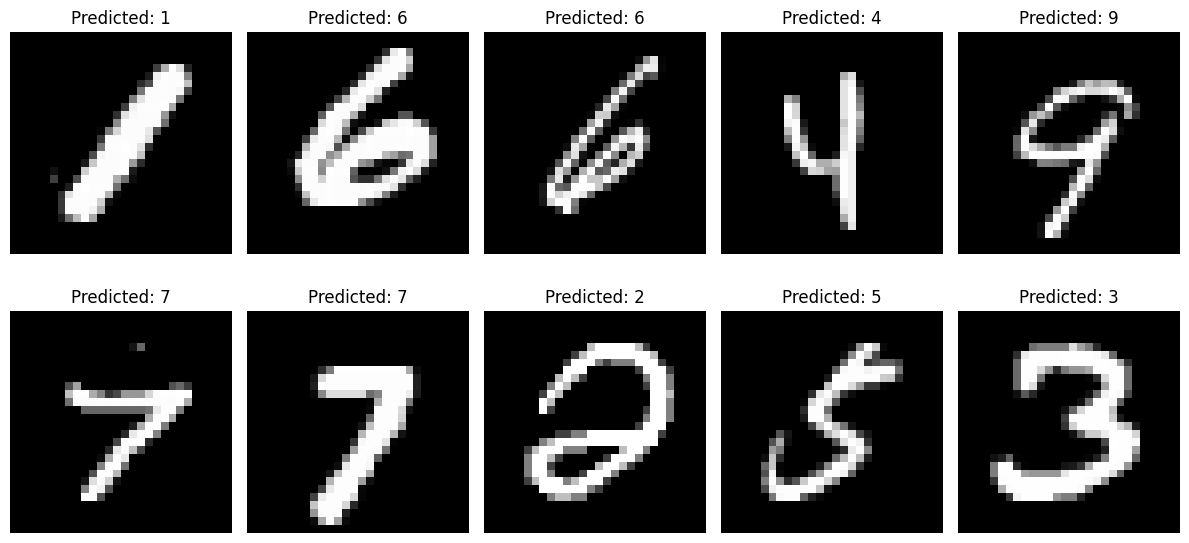

In [23]:
#Randomly seeing some photo and corresponding prediction

import random

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

random_indices = random.sample(range(len(data)), 10)

for i, index in enumerate(random_indices):
  image = data[index].squeeze().cpu().numpy()
  predicted_label = pred[index].item()  # Access the predicted label

  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(f"Predicted: {predicted_label}")
  axes[i].axis('off')


plt.tight_layout()
plt.show()
